# Multi-Stage Processes Notebook

In [2]:
### Import packages
import polars as pl
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import itertools
from collections import Counter

# For plotting
import seaborn as sns

sns.set_theme(style="ticks")
sns.axes_style("darkgrid")
sns.set_theme()

from IPython.display import display, HTML

# For storing DataFrames
import pickle

import sys
from os import getcwd
sys.path.append(getcwd())
import MultiStagePackage.OptMSPfunctions as msp
from MultiStagePackage.models import *

from itertools import islice
import collections
from ast import literal_eval

# For optimization
from pygmo import *

In [3]:
### Prepare data

## Models
models_numeric = [WT_anaerob_growth, 
          LC_anaerob_growth, 
          WT_aerob_growth, 
          LC_aerob_growth, 
          WT_anaerob_growth_arrest, 
          LC_anaerob_growth_arrest]

models_analytic = [WT_anaerob_growth_analyt, 
          LC_anaerob_growth_analyt, 
          WT_aerob_growth_analyt, 
          LC_aerob_growth_analyt, 
          WT_anaerob_growth_arrest_analyt, 
          LC_anaerob_growth_arrest_analyt]

## initial conditions
X_0 = 0.1    # gDW/L
S_0 = 100.0  # mmol/L 
P_0 = 0.0    # mmol/L
s = np.array([X_0, S_0, P_0])

## Indexing
X, S, P = (i for i in range(len(s)))
r_S, r_P, mu = (i for i in range(3))

## Brute force approaches



If the user wants to not only try out single module/time-switch combinations, but rather many different settings then the functions ```do_brute_force_ana()``` and ```do_brute_force_num()``` are provided.

**do_brute_force_ana()** = function that takes as many different combinations of different parameters and times as the user provides and calculates those analytically
- ```do_brute_force_ana(combis, models, n_stages, t_start, t_end, min_duration, s, density=1, indexes=[0,1,2], decimal=3)```
  - ```combi```     = combinations as list of tuples (e.g. ```[(0, 0), (0, 1), ... , (5, 5)]```) (can be generated by ```itertools.product()```)
  - ```models```    = all analytic models in list format
  - ```n_stages```  = max number of stages the user wants to analyze (e.g. ```2``` for 2-stage)
  - ```t_start```   = start time (e.g. ```0```)
  - ```t_end```     = end time (e.g. ```24```)
  - ```min_duration``` = minimum duration for a stage (e.g. ```1```, meaning that all stages are at least 1 hour active)
  - ```s```         = initial values for species as numpy array (e.g. ```array([  0.1, 100. ,   0. ])```)
  - ```density```   = density of time switches (e.g. ```1``` -> time switches are only tested at full hours; ```2``` -> time switches can occur every half hour); default=1
  - ```indexes```   = array of indexes denoting at which index biomass, substrate, product (exactly in this order) occur (e.g ```array([ 0, 1, 2])```)
  - ```decimal```   = how many decimals after rounding should be contained; Default: ```3```
  - **OUTPUT**= returns a DataFrame including:
    - *combi*   = all important time points: (```t_start```, switching time 1, switching time 2, ..., ```t_end```)
    - *Mod*     = modules/stages used (e.g. ```(0,0)```, this is basically an one-stage taking for both stages the same module that is the row with index 0 in the parameter 2D numpy array stored in the variable ```par```)
    - *End_T*   = end time (when fermentation finished meaning when Substrate=0, if fermentation did not finished then ```t_end``` is set)
    - *End_X*   = biomass (at End_T)
    - *End_S*   = substrate (at End_T)
    - *End_P*   = product (at End_T)
    - *finished*= variable displaying stage at which fermentation finished as integer (e.g. ```2``` = finished in stage 2 (stop is set at when substrate = 0))
    - *Vol_P*   = volumetric yield (= *End_P* / *End_T*)
    - *Y_SubInput*= yield based on input substrate (= *End_P* / initial substrate)
    - *Y_SubUsed* = yield based on consumed substrate (= *End_P* / (initial substrate - *End_S*))

<br/>

**do_brute_force_num()** = function that takes as many different combinations of different parameters and times as the user provides and calculates those simulation/ODE-based
- ```do_brute_force_num(combis, models, n_stages, t_start, t_end, min_duration, s, events, step=0.01, density=1, arguments=None, indexes=[0,1,2], event_terminal=True, decimal=3)```
  - ```combi```     = combinations as list of tuples (e.g. ```[(0, 0), (0, 1), ... , (5, 5)]```) (can be generated by ```itertools.product```)
  - ```models```    = all ODE/numeric models in list format
  - ```n_stages```  = max number of stages the user wants to analyze (e.g. ```2``` for 2-stage)
  - ```t_start```   = start time (e.g. ```0```)
  - ```t_end```     = end time (e.g. ```24```)
  - ```min_duration``` = minimum duration for a stage (e.g. ```1```, meaning that all stages are at least 1 hour (or whatever time unit you use) active)
  - ```s```         = initial values for species as numpy array (e.g. ```array([  0.1, 100. ,   0. ])```)
  - ```events```    = (list of functions): events such as ```event_sub0``` (trigger at specific time points in integration)
  - ```step```      = maximal step size in integrator: ```scipy.integrate.solve_ivp()``` as float and default=0.01
  - ```density```   = density of time switches (e.g. ```1``` -> time switches are only tested at full hours; ```2``` -> time switches can occur every half hour); default=1
  - ```arguments``` = additional auxiliary variables for models (e.g. rates). They are not constant and can change over the period of integration (see CaseStudy_klamt2018)
  - ```indexes```   = array of indexes denoting at which index biomass, substrate, product (exactly in this order) occur (e.g ```array([ 0, 1, 2])```)
  - ```event_terminal``` = check if integration should stop when event was triggered or not; Default: ```True```
  - ```decimal```   = how many decimals after rounding should be contained; Default: ```3```
  - **OUTPUT**= same as ```do_brute_force_ana()``` output

In [27]:
%%time
## Example: analytical-based 2-Stage with all time switch combinations possible between 0 and 24 with a minimal duration of 2 hour for each stage
t_start = 0
t_end = 24
min_duration = 2
n_stages = 2
combis = list(itertools.product([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]))  # all combinations for 2-stage: [(0, 0), (0, 1), ... , (5, 5)]

MSPAnalyt_2Stage = msp.do_brute_force_ana(combis, models_analytic, n_stages, t_start, t_end, min_duration, s)
MSPAnalyt_2Stage

CPU times: user 87.5 ms, sys: 4 ms, total: 91.5 ms
Wall time: 90.7 ms


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 2.0, 24.0)","[1, 1]",16.952,0.906,0.000,161.872,2,9.549,1.619,1.619
1,2,"(0.0, 3.0, 24.0)","[1, 1]",16.952,0.906,0.000,161.872,2,9.549,1.619,1.619
2,3,"(0.0, 4.0, 24.0)","[1, 1]",16.952,0.906,0.000,161.872,2,9.549,1.619,1.619
3,4,"(0.0, 5.0, 24.0)","[1, 1]",16.952,0.906,0.000,161.872,2,9.549,1.619,1.619
4,5,"(0.0, 6.0, 24.0)","[1, 1]",16.952,0.906,0.000,161.872,2,9.549,1.619,1.619
...,...,...,...,...,...,...,...,...,...,...,...
565,566,"(0.0, 18.0, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
566,567,"(0.0, 19.0, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
567,568,"(0.0, 20.0, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
568,569,"(0.0, 21.0, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879


In [4]:
%%time
## Example: simulation-based 2-Stage with all time switch combinations possible between 0 and 24 with a minimal duration of 2 hour for each stage

# define the event (here when substrate is 0)
def event_sub0(t,y):
    if(y[S] <= 0.001):
        return 0    # 0 that event triggers
    return 1

t_start = 0
t_end = 24
min_duration = 2
n_stages = 2
combis = list(itertools.product([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]))

MSPSimul_2Stage = msp.do_brute_force_num(   combis = combis, 
                                            models = models_numeric, 
                                            n_stages = n_stages, 
                                            t_start = t_start, 
                                            t_end = t_end, 
                                            min_duration = min_duration, 
                                            s = s, 
                                            events = [event_sub0])
MSPSimul_2Stage

CPU times: user 1min 8s, sys: 22.2 ms, total: 1min 8s
Wall time: 1min 8s


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 2.0, 24.0)","[1, 1]",16.952,0.906,0.001,161.871,2,9.549,1.619,1.619
1,2,"(0.0, 3.0, 24.0)","[1, 1]",16.952,0.906,0.001,161.871,2,9.549,1.619,1.619
2,3,"(0.0, 4.0, 24.0)","[1, 1]",16.952,0.906,0.001,161.871,2,9.549,1.619,1.619
3,4,"(0.0, 5.0, 24.0)","[1, 1]",16.952,0.906,0.001,161.871,2,9.549,1.619,1.619
4,5,"(0.0, 6.0, 24.0)","[1, 1]",16.952,0.906,0.001,161.871,2,9.549,1.619,1.619
...,...,...,...,...,...,...,...,...,...,...,...
565,566,"(0.0, 18.0, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
566,567,"(0.0, 19.0, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
567,568,"(0.0, 20.0, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
568,569,"(0.0, 21.0, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879


Note: As can be seen the simulation-based approach takes significantly longer than the analytical solution. In our case where the functions can be expressed within an analytical way, it is better to perform the ```do_brute_force_ana()```. But if more species or complexity within the species are incorporated, the simulation-based approach will be the way to go since no analytical solution can be found.

Also if you compare the two DataFrames of ```MSPAnalyt_2Stage``` and ```MSPSimul_2Stage``` they show the same results in most entries. However, some integration results are slightly different compared to the analytical results such that ```MSPSimul_2Stage.equals(MSPAnalyt_2Stage)``` will return false. 

In [5]:
%%time
## Example: 3-Stage with all time switch combinations possible between 0 and 24 with a minimal duration of 1 hours for each stage
t_start = 0
t_end = 24
min_duration = 1
n_stages = 2
combis = list(
    itertools.product([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5])
)

MSPAnalyt_3Stage = msp.do_brute_force_ana(combis, models_analytic, n_stages, t_start, t_end, min_duration, s, density=4)
MSPAnalyt_3Stage

CPU times: user 331 ms, sys: 0 ns, total: 331 ms
Wall time: 330 ms


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 24.0)","[1, 1]",16.952,0.906,-0.000,161.872,2,9.549,1.619,1.619
1,2,"(0.0, 1.25, 24.0)","[1, 1]",16.952,0.906,-0.000,161.872,2,9.549,1.619,1.619
2,3,"(0.0, 1.5, 24.0)","[1, 1]",16.952,0.906,0.000,161.872,2,9.549,1.619,1.619
3,4,"(0.0, 1.75, 24.0)","[1, 1]",16.952,0.906,0.000,161.872,2,9.549,1.619,1.619
4,5,"(0.0, 2.0, 24.0)","[1, 1]",16.952,0.906,0.000,161.872,2,9.549,1.619,1.619
...,...,...,...,...,...,...,...,...,...,...,...
2329,2330,"(0.0, 22.0, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
2330,2331,"(0.0, 22.25, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
2331,2332,"(0.0, 22.5, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
2332,2333,"(0.0, 22.75, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879


In [7]:
%%time
## Example: 4-Stage with all time switch combinations possible between 0 and 20 with a minimal duration of 3 hours for each stage
t_start = 0
t_end = 20
min_duration = 3
n_stages = 4
combis = list(itertools.product([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]))

MSPAnalyt_4Stage = msp.do_brute_force_ana(combis, models_analytic, n_stages, t_start, t_end, min_duration, s)
MSPAnalyt_4Stage

CPU times: user 19.6 s, sys: 28.6 ms, total: 19.6 s
Wall time: 19.6 s


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 3.0, 6.0, 9.0, 20.0)","[1, 1, 1, 1]",16.952,0.906,0.00,161.872,4,9.549,1.619,1.619
1,2,"(0.0, 3.0, 6.0, 10.0, 20.0)","[1, 1, 1, 1]",16.952,0.906,0.00,161.872,4,9.549,1.619,1.619
2,3,"(0.0, 3.0, 6.0, 11.0, 20.0)","[1, 1, 1, 1]",16.952,0.906,0.00,161.872,4,9.549,1.619,1.619
3,4,"(0.0, 3.0, 6.0, 12.0, 20.0)","[1, 1, 1, 1]",16.952,0.906,0.00,161.872,4,9.549,1.619,1.619
4,5,"(0.0, 3.0, 6.0, 13.0, 20.0)","[1, 1, 1, 1]",16.952,0.906,0.00,161.872,4,9.549,1.619,1.619
...,...,...,...,...,...,...,...,...,...,...,...
137275,137276,"(0.0, 9.0, 14.0, 17.0, 20.0)","[6, 6, 6, 6]",20.000,0.100,81.26,35.220,inf,1.761,0.352,1.879
137276,137277,"(0.0, 10.0, 13.0, 16.0, 20.0)","[6, 6, 6, 6]",20.000,0.100,81.26,35.220,inf,1.761,0.352,1.879
137277,137278,"(0.0, 10.0, 13.0, 17.0, 20.0)","[6, 6, 6, 6]",20.000,0.100,81.26,35.220,inf,1.761,0.352,1.879
137278,137279,"(0.0, 10.0, 14.0, 17.0, 20.0)","[6, 6, 6, 6]",20.000,0.100,81.26,35.220,inf,1.761,0.352,1.879


In [9]:
%%time
## Example: simulation-based 2-Stage with all time switch combinations possible between 0 and 24
# with a minimal duration of 1 hour for each stage
# and switching time points possible to appear every half hour
t_start = 0
t_end = 24
min_duration = 1
n_stages = 2
combis = list(itertools.product([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]))

MSPSimul_2Stage_density2 = msp.do_brute_force_num(combis, models_numeric, n_stages, t_start, t_end, min_duration, s, [event_sub0], density=2)
MSPSimul_2Stage_density2

CPU times: user 2min 24s, sys: 4.67 ms, total: 2min 24s
Wall time: 2min 24s


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 24.0)","[1, 1]",16.952,0.906,0.001,161.871,2,9.549,1.619,1.619
1,2,"(0.0, 1.5, 24.0)","[1, 1]",16.952,0.906,0.001,161.871,2,9.549,1.619,1.619
2,3,"(0.0, 2.0, 24.0)","[1, 1]",16.952,0.906,0.001,161.871,2,9.549,1.619,1.619
3,4,"(0.0, 2.5, 24.0)","[1, 1]",16.952,0.906,0.001,161.871,2,9.549,1.619,1.619
4,5,"(0.0, 3.0, 24.0)","[1, 1]",16.952,0.906,0.001,161.871,2,9.549,1.619,1.619
...,...,...,...,...,...,...,...,...,...,...,...
1183,1184,"(0.0, 21.0, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
1184,1185,"(0.0, 21.5, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
1185,1186,"(0.0, 22.0, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
1186,1187,"(0.0, 22.5, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879


In [10]:
%%time
## Example: simulation-based 2-Stage with all time switch combinations possible between 0 and 24
# with a minimal duration of 1 hour for each stage
# and switching time points possible to appear every quarter hour
t_start = 0
t_end = 24
min_duration = 1
n_stages = 2
combis = list(itertools.product([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]))

MSPSimul_2Stage_density4 = msp.do_brute_force_num(combis, models_numeric, n_stages, t_start, t_end, min_duration, s, [event_sub0], density=4)
MSPSimul_2Stage_density4

CPU times: user 4min 40s, sys: 292 µs, total: 4min 40s
Wall time: 4min 40s


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 24.0)","[1, 1]",16.952,0.906,0.001,161.871,2,9.549,1.619,1.619
1,2,"(0.0, 1.25, 24.0)","[1, 1]",16.952,0.906,0.001,161.871,2,9.549,1.619,1.619
2,3,"(0.0, 1.5, 24.0)","[1, 1]",16.952,0.906,0.001,161.871,2,9.549,1.619,1.619
3,4,"(0.0, 1.75, 24.0)","[1, 1]",16.952,0.906,0.001,161.871,2,9.549,1.619,1.619
4,5,"(0.0, 2.0, 24.0)","[1, 1]",16.952,0.906,0.001,161.871,2,9.549,1.619,1.619
...,...,...,...,...,...,...,...,...,...,...,...
2329,2330,"(0.0, 22.0, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
2330,2331,"(0.0, 22.25, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
2331,2332,"(0.0, 22.5, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
2332,2333,"(0.0, 22.75, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879


Another important point here is the fact that with increasing number of combinations (coming from e.g. number of stages (```n_stages```), the duration of the fermentation (```t_end```) or a more dense switching time search when those times may be also allowed every half hour (```density```)) makes the trade-off between time and knowledge obvious. More combinations = longer calculations. 

That's why we also provided this package with an optimizer approach, which is explained below 

### Filtering/searching output DataFrames

In [11]:
### Filter the 5 best performing volumetric productivity values:
print("Best results 2-stage analytical-based:")
display(
    MSPAnalyt_2Stage.sort_values(["Vol_P"], ascending=[False])
    .dropna(axis=0)
    .drop_duplicates(subset="Models", keep="first")[:5]
)
print("Best results 2-stage simulation-based:")
display(
    MSPSimul_2Stage.sort_values(["Vol_P"], ascending=[False])
    .dropna(axis=0)
    .drop_duplicates(subset="Models", keep="first")[:5]
)
print("Best results 3-stage analytical-based:")
display(
    MSPAnalyt_3Stage.sort_values(["Vol_P"], ascending=[False])
    .dropna(axis=0)
    .drop_duplicates(subset="Models", keep="first")[:5]
)
print("Best results 4-stage analytical-based:")
display(
    MSPAnalyt_4Stage.sort_values(["Vol_P"], ascending=[False])
    .dropna(axis=0)
    .drop_duplicates(subset="Models", keep="first")[:5]
)

Best results 2-stage analytical-based:


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
281,282,"(0.0, 5.0, 24.0)","[4, 2]",7.845,1.445,-0.0,156.088,2,19.896,1.561,1.561
233,234,"(0.0, 5.0, 24.0)","[3, 2]",7.464,1.561,-0.0,147.777,2,19.798,1.478,1.478
273,274,"(0.0, 5.0, 24.0)","[4, 1]",8.478,1.915,0.0,140.040,2,16.519,1.400,1.400
225,226,"(0.0, 5.0, 24.0)","[3, 1]",8.064,2.005,0.0,132.595,2,16.443,1.326,1.326
314,315,"(0.0, 6.0, 24.0)","[4, 6]",10.080,2.009,0.0,144.628,2,14.348,1.446,1.446


Best results 2-stage simulation-based:


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
281,282,"(0.0, 5.0, 24.0)","[4, 2]",7.845,1.445,0.001,156.087,2,19.896,1.561,1.561
233,234,"(0.0, 5.0, 24.0)","[3, 2]",7.464,1.561,0.001,147.775,2,19.798,1.478,1.478
273,274,"(0.0, 5.0, 24.0)","[4, 1]",8.478,1.915,0.001,140.038,2,16.518,1.400,1.400
225,226,"(0.0, 5.0, 24.0)","[3, 1]",8.064,2.005,0.001,132.594,2,16.443,1.326,1.326
314,315,"(0.0, 6.0, 24.0)","[4, 6]",10.080,2.009,0.001,144.627,2,14.347,1.446,1.446


Best results 3-stage analytical-based:


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
932,933,"(0.0, 4.5, 24.0)","[3, 2]",7.788,1.265,0.0,155.857,2,20.013,1.559,1.559
1116,1117,"(0.0, 4.75, 24.0)","[4, 2]",7.998,1.306,0.0,159.206,2,19.905,1.592,1.592
903,904,"(0.0, 4.75, 24.0)","[3, 1]",8.237,1.860,0.0,136.451,2,16.565,1.365,1.365
1084,1085,"(0.0, 5.0, 24.0)","[4, 1]",8.478,1.915,0.0,140.040,2,16.519,1.400,1.400
1253,1254,"(0.0, 6.0, 24.0)","[4, 6]",10.080,2.009,0.0,144.628,2,14.348,1.446,1.446


Best results 4-stage analytical-based:


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
66807,66808,"(0.0, 5.0, 8.0, 11.0, 20.0)","[4, 2, 1, 1]",7.845,1.445,-0.0,156.088,2,19.896,1.561,1.561
66867,66868,"(0.0, 5.0, 8.0, 11.0, 20.0)","[4, 2, 1, 4]",7.845,1.445,-0.0,156.088,2,19.896,1.561,1.561
67081,67082,"(0.0, 5.0, 8.0, 11.0, 20.0)","[4, 2, 3, 4]",7.845,1.445,-0.0,156.088,2,19.896,1.561,1.561
67645,67646,"(0.0, 5.0, 8.0, 11.0, 20.0)","[4, 2, 6, 2]",7.845,1.445,-0.0,156.088,2,19.896,1.561,1.561
67193,67194,"(0.0, 5.0, 8.0, 11.0, 20.0)","[4, 2, 4, 4]",7.845,1.445,-0.0,156.088,2,19.896,1.561,1.561


You can look at the best result from the four different runs above and see that three out of the four found the same optimum. The optimal solution found here is a 2-stage with the modules 0 and 3, having a switching time at t=5. Even though we run all the combinations possible for a 4 stage setting, the *End_T* tells us that the fermentation always stops in those three runs in stage 2, which is also reflected in the *finished* column (returning 2).

Only the 3-Stage approach with 1 hour minimal duration of stages found a better solution when filtering after volumetric productivity.  

In [12]:
# One example on how the user can filter after <end product>
print("Best product results 2-stage simulation-based:")
display(
    MSPSimul_2Stage.sort_values(["End_P"], ascending=[False])
    .dropna(axis=0)
    .drop_duplicates(subset="Models", keep="first")[:5]
)

Best product results 2-stage simulation-based:


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
219,220,"(0.0, 20.0, 24.0)","[2, 6]",23.730,0.332,0.001,181.314,2,7.641,1.813,1.813
465,466,"(0.0, 2.0, 24.0)","[6, 2]",23.235,0.358,0.001,180.585,2,7.772,1.806,1.806
179,180,"(0.0, 22.0, 24.0)","[2, 4]",21.463,0.362,0.001,180.445,1,8.407,1.804,1.804
200,201,"(0.0, 22.0, 24.0)","[2, 5]",21.463,0.362,0.001,180.445,1,8.407,1.804,1.804
158,159,"(0.0, 22.0, 24.0)","[2, 3]",21.463,0.362,0.001,180.445,1,8.407,1.804,1.804


## Optimizer approaches


    

With the increase of combinations and the wish to search for optimal switching times that can be set as continuous variable, the optimizer approach is presented here.

The package [pygmo](https://esa.github.io/pygmo2/) (with the [IHS](https://esa.github.io/pygmo2/algorithms.html) algorithm) is used, which requires to define an own class for the multi-stage optimization problem: ```class Optimizer```.


```class Optimizer:``` 
  - ```__init__(self, s, models, indexes, tstart, tend, max_stage, min_duration, objective, optmod, calc_option=numeric_option, arguments=None, events=None, extracon=[], extracon_vals=[], extracon_optmod=[], step=0.01, event_terminal=True)```
    - ```s```         = initial values for species as numpy array (e.g. ```array([  0.1, 100. ,   0. ])```)
    - ```models```    = all models in list format -> which kind of models (analytic or numeric) is decided by the user and needs to be set accordingly in the parameter ```opt```
    - ```indexes```   = array of indexes denoting at which index biomass, substrate, product (exactly in this order) occur (e.g ```array([ 0, 1, 2])```)
    - ```tstart```    = start time as int (e.g. ```0```) 
    - ```tend```      = end time as int (e.g. ```24```)
    - ```max_stage```  = max number of stages the user wants to analyze (e.g. ```2``` for 2-stage)
    - ```min_duration``` = minimum duration for a stage (e.g. ```1```, meaning that all stages are at least 1 hour (or whatever time unit you use) active)
    - ```objective``` = function that will be evaluated in the objective(self, x) function defined in the optimizer (score will be calculated based on this input function) 
    - ```optmod```    = modus of optimization either ```"max"``` or ```"min"``` 
    - ```calc_option``` = which calculation option/ type of models you have (```numeric_option``` or ```analytic_option```; Those are functions!!)
    - ```arguments``` = list of auxiliary variables (e.g. in the form ```(aux,)``` ); Default: ```None```  
    - ```events```    = events such as ```event_sub0``` (trigger at specific time points in integration); Default: ```None```
    - ```extracon```  = extra constraints as list; default=```None```
    - ```extracon_vals``` = values for the corresponding constraints provided in extracon; Default: ```[]``` 
    - ```extracon_optmod``` = denotion if ```extracon_vals``` is greater or lower than the constraint value use ```"greater_than"``` or ```"lower_than"```; Default: ```[]```
    - ```step```      = maximal step size in integrator: ```scipy.integrate.solve_ivp()``` as float and default=```0.01``` 
    - ```event_terminal``` = check if integration should stop when event was triggered or not; Default: ```True```

  - **OUTPUT**= class object 

  <br/> 

**do_opt_to_df()** = function that takes the extracted log of the problem and outputs an interpretable dataframe with the ```n_best``` performing scores of the optimization
- ```do_opt_to_df(df, n_best)```
  - ```df```      = Daftaframe containing log of optimization problem
  - ```n_best```  = number of best performing scores that will be returned

  <br/> 

  - **OUTPUT**= 3 outputs:
    - list of ```n_best``` tswitches as numeric values
    - list of ```n_best``` models as numeric values
    - Dataframe with the ```n_best``` candidates with columns:
      - *Score*   = is the value of the measure that was set at ```obj``` to be optimized; can be ```'Vol_P'``` for volumetric productivity or ```'Titer'``` for titer
      - *Mod*     = modules/stages used (e.g. ```(0,0)```, this is basically an one-stage taking for both stages the same module that is the row with index 0 in the parameter 2D numpy array stored in the variable ```par```)
      - *combi*   = all important time points: (```t_start```, switching time 1, switching time 2, ..., ```t_end```)

  <br/> 

**do_convert()** = function that takes the extracted log of the problem and outputs an interpretable dataframe with the ```n_best``` performing scores of the optimization
- ```do_convert(opt_res, models_num, t_start, t_end, s, events, arguments=None, indexes=[0,1,2], step=0.01, event_terminal=True, decimal=3)```
  - ```opt_res```     = Output from ```do_opt_to_df()```
  - ```models_num```  = numeric models as list
  - ```t_start```     = start time of fermentation (e.g. ```0```) (same values you set in optimization)
  - ```t_end```       = end time of fermentation (e.g. ```24```) (same values you set in optimization)
  - ```s```           = initial values for species as numpy array (e.g. ```array([  0.1, 100. ,   0. ])```) (same values you set in optimization)
  - ```events```    = events such as ```event_sub0``` (trigger at specific time points in integration); Default: ```None```
  - ```arguments``` = list of auxiliary variables (e.g. in the form ```(aux,)``` ); Default: ```None```  
  - ```indexes```   = array of indexes denoting at which index biomass, substrate, product (exactly in this order) occur (e.g ```array([ 0, 1, 2])```)
  - ```step```        = aximal step size in integrator: ```scipy.integrate.solve_ivp()``` as float and default=```0.01```
  - ```event_terminal``` = check if integration should stop when event was triggered or not; Default: ```True```
  - ```decimal```   = how many decimals after rounding should be contained; Default: ```3```

  <br/> 

  - **OUTPUT**= dataframe with the same format as the brute force approach

### Example with constraint

In [17]:
%%time
### Steps for optimization:

## 1.) Volumetric productivity
def volprod(simulation, indexes, initial_values, tstart, tend):
    return simulation[P]/(simulation[-2]-tstart)

## Optional: Define constraint (here yield)
def constraint_product_yield(simulation, indexes, initial_values, tstart, tend):
    return simulation[P]/(initial_values[S]-simulation[S])

## Also if you have numerical optimization define event:
def event_sub0(t,y):
    if(y[S] <= 0.001):
        return 0    # 0 that event triggers
    return 1

## 2.) Define the algorithm that will be used (in our case IHS) with the number of generations (fitness function evaluations) and a seed for reproducibility
# Note: per default there are always 10 evaluations so the total number of fitness function evaluations is 10 + the number of you pass to the gen attribute
algo_ihs = algorithm(ihs(gen=5000, seed=12345))  # total numer of evaluations = 10 + 5000
algo_ihs.set_verbosity(50)  # output best performing each 50th generation

## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
problem_num_volP = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,                                # initial values of species
            models=models_numeric,              # The functions of the models 
            indexes=[X, S, P],                  # indexes to denote at which position in the model are biomass, substrate and product (default is [0,1,2]; -> see for more information ModelingTutorial.ipynb notebook)
            tstart=0,                           # start time of process
            tend=24,                            # end time of process
            max_stage=3,                        # The maximum stages the user wants to test out (optimal solution might turn out to not have as many stages)
            min_duration=1,                     # minimal duration of each sub-process/module
            objective=volprod,                  # Objective function 
            optmod="max",                       # Maximization or minimization? ("max" or "min")
            calc_option=msp.numeric_option,     # Numeric models as imput
            events=[event_sub0],                # event function for denoting real end time of fermentation (here when no substrate is present anymore; in other use cases different)
            extracon=[constraint_product_yield], # Constraints function(s) (input as list!!)
            extracon_vals=[1.5],                # The values for the corresponding constraints provided in extracon (input as list!!)
            extracon_optmod=["greater_than"]    # The denotion if extracon_vals is greater or lower than the constraint value (here it means therefore: yield > 1.662) use "greater_than" or "lower_than"
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
# Define a relative tolerance that 
problem_num_volP.c_tol = 1e-3

## 4.) Starting the optimization
result_num_volP = algo_ihs.evolve(population(problem_num_volP, size=10, seed=12345))  # start with 10 candidate solutions


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350128         0.9977        30.0108         4.8844              0              0        -4.8844
     51       0.356528       0.889201        8.09932        5.36641              0              0       -9.95855
    101       0.362928       0.792501        21.6209        4.34539              0              0       -12.7527
    151       0.369328       0.706318        8.92157        9.77924              0              0       -19.7378
    201       0.375728       0.629506        7.17621        1.59095              0              0       -19.7992
    251       0.382128       0.561048        5.10407       0.390625              0              0       -19.8466
    301       0.388528       0.500035        11.3169       0.223744              0              0       -20.0229
    351       0.394928       0.445656              4       0.223744              0             

After optimization we can look at the output object:

In [18]:
result_num_volP

Problem name: <class 'MultiStagePackage.OptMSPfunctions.Optimizer'> [decorated]
	C++ class name: pybind11::object

	Global dimension:			5
	Integer dimension:			3
	Fitness dimension:			3
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	2
	Tolerances on constraints: [0.001, 0.001]
	Lower bounds: [1, 2, 0, 0, 0]
	Upper bounds: [22, 23, 5, 5, 5]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 5010

	Thread safety: none

Extra info:
	Registered decorators:
		fitness

Population size: 10

List of individuals: 
#0:
	ID:			9707694384378740006
	Decision vector:	[4.60896, 9.27987, 2, 1, 1]
	Fitness vector:		[-20.029, -3.67091, -0.0427013]
#1:
	ID:			11001011141740851168
	Decision vector:	[4.60896, 9.2575, 2, 1, 1]
	Fitness vector:		[-20.029, -3.64854, -0.0427013]
#2:
	ID:			958447497090921477
	Decision vector

The data itself has to be extracted out of the object via the ```do_opt_to_df()``` function (for description see above):

In [19]:
# 1) Extract the log out of the optimization object (we exclude the first row since this is a initialization row and does not have the same format as the other rows):
log = pd.DataFrame(result_num_volP.problem.extract(decorator_problem).dv_log)[1:] 

# 2) Do extraction for the number of best combinations you choose:
best_res_num = msp.do_opt_to_df(  df=log,     # log dataframe from optimization
                                    n_best=1)  # Number of best performing processes that are returned

# 3) Convert the solutions from best_res_num into the same format as in the brute force solution dataframe:
df_num=msp.do_convert(opt_res=best_res_num,             # Output from do_opt_to_df()
                    models_num=models_numeric,          # models (in numeric form)
                    t_start=0, 
                    t_end=20, 
                    s=s, 
                    events=[event_sub0], 
                    indexes=[X, S, P])

Constraints found. Dataframe is filtered first


In [20]:
df_num

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 4.605, 9.257, 20.0]","[3, 2, 2]",7.705,1.321,0.0,154.322,2,20.029,1.543,1.543


### Example without constraint

In [12]:
%%time
### Steps for optimization:

## 1.) Volumetric productivity
def volprod(simulation, indexes, initial_values, tstart, tend):
    return simulation[P]/(simulation[-2]-tstart)

## Also if you have numerical optimization define event:
def event_sub0(t,y):
    if(y[S] <= 0.001):
        return 0    # 0 that event triggers
    return 1


## 2.) Define the algorithm that will be used (in our case IHS) with the number of generations (fitness function evaluations) and a seed for reproducibility
# Note: per default there are always 10 evaluations so the total number of fitness function evaluations is 10 + the number of you pass to the gen attribute
algo_ihs = algorithm(ihs(gen=1000, seed=12345))
algo_ihs.set_verbosity(50)  # output best performing each 50th generation

## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
problem_num_volP2 = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,                                # initial values of species
            models=models_numeric,              # The functions of the models 
            indexes=[X, S, P],                  # indexes to denote at which position in the model are biomass, substrate and product (default is [0,1,2]; -> see for more information ModelingTutorial.ipynb notebook)
            tstart=0,                           # start time of process
            tend=24,                            # end time of process
            max_stage=3,                        # The maximum stages the user wants to test out (optimal solution might turn out to not have as many stages)
            min_duration=1,                     # minimal duration of each sub-process/module
            objective=volprod,                  # Objective function 
            optmod="max",                       # Maximization or minimization? ("max" or "min")
            calc_option=msp.numeric_option,     # Numeric models as imput
            events=[event_sub0],                # event function for denoting real end time of fermentation (here when no substrate is present anymore; in other use cases different)
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
problem_num_volP2.c_tol = 1e-3 

## 4.) Starting the optimization
result_num_volP2 = algo_ihs.evolve(
    population(problem_num_volP2, size=10, seed=12345)
)  # start with 10 candidate solutions


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1        0.35064       0.988553        30.0108         4.8844              0              0        -4.8844
     51        0.38264       0.555904        16.7328        9.42929              0              0       -15.7729
    101        0.41464       0.312608        13.0858        8.51993              0              0       -18.1939
    151        0.44664       0.175792        15.7134        5.08603              0              0       -18.1939
    201        0.47864      0.0988553        2.49881        3.18738              0              0       -20.0269
    251        0.51064      0.0555904        3.43115        1.27751              0              0       -20.0269
    301        0.54264      0.0312608        7.06406       0.985635              0              0       -20.0269
    351        0.57464      0.0175792        2.05782       0.950275              0             

In [13]:
# 1) Extract the log out of the optimization object (we exclude the first row since this is a initialization row and does not have the same format as the other rows):
log2 = pd.DataFrame(result_num_volP2.problem.extract(decorator_problem).dv_log)[1:] 

# 2) Do extraction for the number of best combinations you choose:
best_res_num2 = msp.do_opt_to_df(  df=log2,     # log dataframe from optimization
                                    n_best=1)  # Number of best performing processes that are returned

# 3) Convert the solutions from best_res_num into the same format as in the brute force solution dataframe:
df_num2=msp.do_convert(opt_res=best_res_num2,           # Output from do_opt_to_df()
                    models_num=models_numeric,          # models (in numeric form)
                    t_start=0, 
                    t_end=20, 
                    s=s, 
                    events=[event_sub0], 
                    indexes=[X, S, P])

No constraints found.


In [16]:
df_num2

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 4.614, 13.829, 20.0]","[3, 2, 3]",7.699,1.325,0.001,154.198,2,20.029,1.542,1.542


### Example without constraints and analytic models

In [21]:
%%time
# Now the same with the analytical method

## Example without extra constraints

## 1.) Volumetric productivity
def volprod(simulation, indexes, initial_values, tstart, tend):
    return simulation[P]/(simulation[-2]-tstart)

## 2.) 
algo_ihs = algorithm(ihs(gen=1000, seed=12345))
algo_ihs.set_verbosity(50)  # output best performing each 50th generation

## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
problem_ana = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,                                # initial values of species
            models=models_analytic,             # The functions of the models 
            indexes=[X, S, P],                  # indexes to denote at which position in the model are biomass, substrate and product (default is [0,1,2]; -> see for more information ModelingTutorial.ipynb notebook)
            tstart=0,                           # start time of process
            tend=24,                            # end time of process
            max_stage=3,                        # The maximum stages the user wants to test out (optimal solution might turn out to not have as many stages)
            min_duration=1,                     # minimal duration of each sub-process/module
            objective=volprod,                  # Objective function 
            optmod="max",                       # Maximization or minimization? ("max" or "min")
            calc_option=msp.analytic_option,    # Numeric models as imput
            events=[event_sub0]                 # event function for denoting real end time of fermentation (here when no substrate is present anymore; in other use cases different)
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
problem_ana.c_tol = 1e-3

## 4.) Starting the optimization
result_ana = algo_ihs.evolve(population(problem_ana, size=10, seed=12345))  # start with 10 candidate solutions


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1        0.35064       0.988553        30.0108         4.8844              0              0        -4.8844
     51        0.38264       0.555904        16.7328        9.42936              0              0        -15.773
    101        0.41464       0.312608        13.0858        8.52003              0              0       -18.1941
    151        0.44664       0.175792        5.19428        5.08607              0              0       -18.1941
    201        0.47864      0.0988553        3.61237        2.51663              0              0       -19.0902
    251        0.51064      0.0555904         7.4684       0.967466              0              0       -20.0089
    301        0.54264      0.0312608         7.4397       0.918714              0              0       -20.0089
    351        0.57464      0.0175792        3.71073       0.266027              0             

In [23]:
# 1) Extract the log out of the optimization object (we exclude the first row since this is a initialization row and does not have the same format as the other rows):
log3 = pd.DataFrame(result_ana.problem.extract(decorator_problem).dv_log)[1:] 

# 2) Do extraction for the number of best combinations you choose:
best_res_ana = msp.do_opt_to_df(  df=log3,     # log dataframe from optimization
                                    n_best=1)  # Number of best performing processes that are returned

# 3) Convert the solutions from best_res_num into the same format as in the brute force solution dataframe:
df_ana=msp.do_convert(opt_res=best_res_ana,             # Output from do_opt_to_df()
                    models_num=models_numeric,          # models (in numeric form)
                    t_start=0, 
                    t_end=20, 
                    s=s, 
                    events=[event_sub0], 
                    indexes=[X, S, P])

No constraints found.


In [24]:
df_ana

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 4.591, 6.998, 20.0]","[3, 2, 2]",7.716,1.313,0.001,154.531,3,20.029,1.545,1.545


## Saving and Loading results

**doSave()** = function that saves optimization results
- ```doSave(df, path)```
  - ```df```    = dataframe  
  - ```path```  = directory where to save dataframe and name for dataframe 

**doLoad()** = function that loads optimization results
- ```doLoad(path)```
  - ```path```  = directory and name of saved dataframe 

In [19]:
## Saving 
# Optimization object
msp.do_save(result_num_volP, './Results/Test_OptimizerObject.obj')

In [20]:
## Loading
# Optimization object
print(msp.do_load('./Results/Test_OptimizerObject.obj'))

Problem name: <class 'MultiStagePackage.OptMSPfunctions.Optimizer'> [decorated]
	C++ class name: pybind11::object

	Global dimension:			7
	Integer dimension:			4
	Fitness dimension:			3
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	2
	Tolerances on constraints: [0.001, 0.001]
	Lower bounds: [1, 2, 3, 0, 0, ... ]
	Upper bounds: [21, 22, 23, 5, 5, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 1010

	Thread safety: none

Extra info:
	Registered decorators:
		fitness

Population size: 10

List of individuals: 
#0:
	ID:			9803520113176807083
	Decision vector:	[4.86316, 8.31695, 15.1589, 3, 1, ... ]
	Fitness vector:		[-19.9196, -2.45379, -5.84197]
#1:
	ID:			3094297982135069923
	Decision vector:	[4.86272, 12.2477, 15.1826, 3, 1, ... ]
	Fitness vector:		[-19.9196, -6.38501, -1.93487]
#2:
	ID:			

## Plotting

Here, a general plotting function ```do_custom_plot()``` is described.

**do_custom_plot()** = function that takes DataFrame outputs from ```do_brute_force_ana()``` and ```do_brute_force_num()``` or optimizer output after the convert() function (see above) to plot the substrate, product and biomass dynamics over time
- ```do_custom_plot(df, models_num, s, title, events, arguments=None, indexes=[0,1,2], step=0.01, with_lines=False, palette="viridis", biomass_ylab='Biomass [gDW/L]', substrate_ylab='Substrate [mmol/L]', product_ylab='Product [mmol/L]')```
  - ```df```      = dataframe you get from: brute force functions (do_brute_force_num and do_brute_force_ana) or optimizer function
  - ```models_num```  = ODE/numeric models in list format
  - ```s```         = initial values for species as numpy array (e.g. ```array([  0.1, 100. ,   0. ])```)
  - ```title```   = title of plot displayed at the top 
  - ```events``` = events such as event_sub0 (trigger at specific time points in integration)
  - ```arguments``` = list of auxiliary variables (e.g. in the form ```(aux,)``` ); Default: ```None```  
  - ```indexes```   = array of indexes denoting at which index biomass, substrate, product (exactly in this order) occur (e.g ```array([ 0, 1, 2])```)
  - ```step```    = maximal step size in integrator: ```scipy.integrate.solve_ivp()``` as float and default=```0.01``` 
  - ```with_lines``` = Decide if additional lines in the plot should be displayed; Default: ```False```
  - ```palette``` = color palette to use; Default: ```"viridis"```
  - ```biomass_ylab``` = Biomass y label in plot; Default: ```'Biomass [gDW/L]'```
  - ```substrate_ylab``` = Substrate y label in plot; Default: ```'Substrate [mmol/L]'```
  - ```product_ylab``` = Product y label in plot; Default: ```'Product [mmol/L]'```
  - **OUTPUT**= plot with substrate, product and biomass dynamics

### For Brute Force

In [28]:
brute_best = MSPAnalyt_2Stage.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:5]
brute_best

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
281,282,"(0.0, 5.0, 24.0)","[4, 2]",7.845,1.445,-0.0,156.088,2,19.896,1.561,1.561
233,234,"(0.0, 5.0, 24.0)","[3, 2]",7.464,1.561,-0.0,147.777,2,19.798,1.478,1.478
273,274,"(0.0, 5.0, 24.0)","[4, 1]",8.478,1.915,0.0,140.040,2,16.519,1.400,1.400
225,226,"(0.0, 5.0, 24.0)","[3, 1]",8.064,2.005,0.0,132.595,2,16.443,1.326,1.326
314,315,"(0.0, 6.0, 24.0)","[4, 6]",10.080,2.009,0.0,144.628,2,14.348,1.446,1.446


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or var

<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

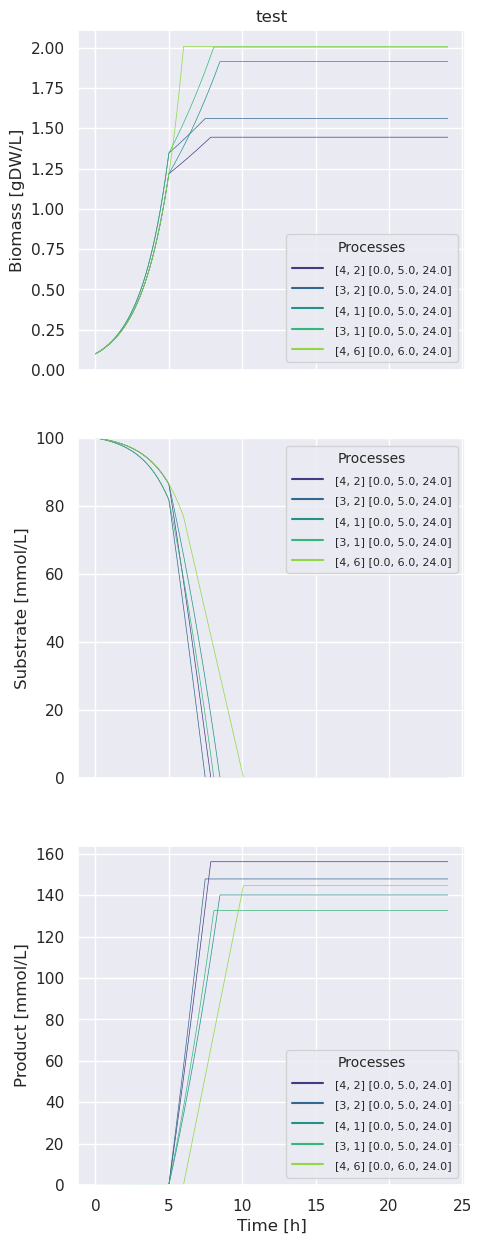

In [29]:
msp.do_custom_plot(df= brute_best, 
                   models_num=models_numeric, 
                   s=s, 
                   title="test",
                   events=[event_sub0],
                   indexes=[X,S,P])

### For Optimizer

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or var

<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

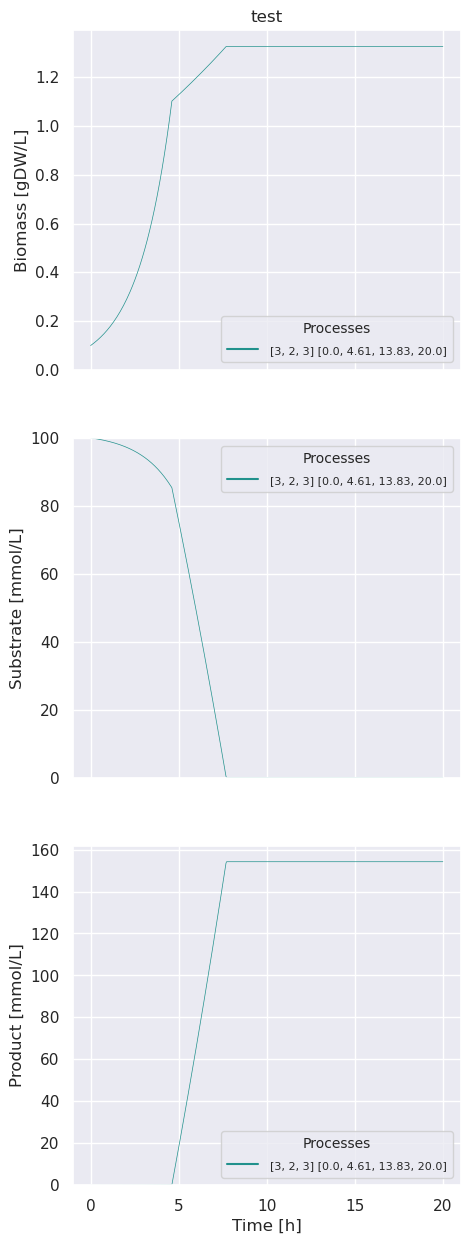

In [30]:
msp.do_custom_plot(df= df_num2, 
                   models_num=models_numeric, 
                   s=s, 
                   title="test",
                   events=[event_sub0],
                   indexes=[X,S,P],)